In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
%matplotlib inline

# Load data

In [35]:
items = pd.read_csv('./data/items.csv')
shops = pd.read_csv('./data/shops.csv')
item_cats = pd.read_csv('./data/item_categories.csv')
sales = pd.read_csv('./data/sales_train.csv.gz')
sample_subs = pd.read_csv('./data/sample_submission.csv.gz')
test = pd.read_csv('./data/test.csv.gz')

# EDA

In [36]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [37]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [38]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [39]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [40]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [41]:
sample_subs.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [42]:
sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


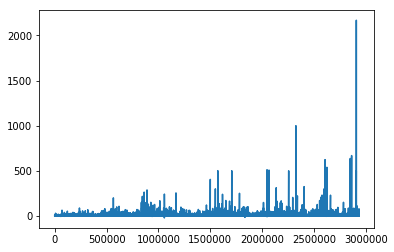

In [43]:
sales['item_cnt_day'].plot()

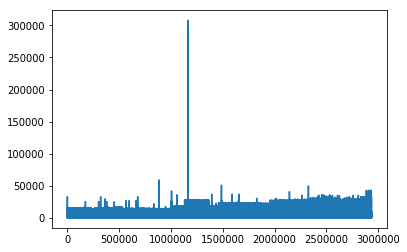

In [44]:
sales['item_price'].plot()

## Remove outliers

In [45]:
sales = sales[sales['item_price'] < 100000]
sales = sales[sales['item_cnt_day'] < 1000]

## Aggregate data

In [46]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

# Compute all shop and item combinations
grid = []
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [47]:
grid.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


Transform the sales data to be grouped by month and fill missing data with 0

In [48]:
sales_in_month = sales.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': 'sum','item_price': np.mean}).reset_index()

In [49]:
sales_in_month = pd.merge(grid, sales_in_month, on=['date_block_num','shop_id','item_id'], how='left').fillna(0)

In [50]:
sales_in_month.rename({'item_cnt_day': 'item_cnt_month'}, axis='columns', inplace=True)

In [51]:
sales_in_month.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price
0,59,22154,0,1.0,999.0
1,59,2552,0,0.0,0.0
2,59,2554,0,0.0,0.0
3,59,2555,0,0.0,0.0
4,59,2564,0,0.0,0.0


Add item info as well

In [52]:
sales_in_month = pd.merge(sales_in_month, items, on=['item_id'], how='left')

In [53]:
sales_in_month.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59


# Mean encoding

In [54]:
id_types = ['item_id', 'shop_id', 'item_category_id']
encoding_methods = [('item_price', np.mean, 'mean'), ('item_cnt_day', np.sum, 'sum'), ('item_cnt_day', np.mean, 'mean')]
sales_with_item_info = pd.merge(sales, items, on=['item_id'], how='left')

for id_type in id_types:
    for column_id, agg, agg_type in encoding_methods:
        new_df = sales_with_item_info.groupby([id_type, 'date_block_num']).aggregate(agg).reset_index()[[column_id, id_type, 'date_block_num']]
        new_df.columns = [id_type + '_' + agg_type + '_' + column_id, id_type, 'date_block_num']
        sales_in_month = pd.merge(sales_in_month, new_df, on=['date_block_num', id_type], how='left')

In [55]:
sales_in_month.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,item_id_mean_item_price,item_id_sum_item_cnt_day,item_id_mean_item_cnt_day,shop_id_mean_item_price,shop_id_sum_item_cnt_day,shop_id_mean_item_cnt_day,item_category_id_mean_item_price,item_category_id_sum_item_cnt_day,item_category_id_mean_item_cnt_day
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,999.00,18.0,1.0,820.174553,2017.0,1.092041,465.036007,6094.0,1.053414
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,899.00,0.0,0.0,820.174553,2017.0,1.092041,1401.858108,287.0,0.969595
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,1709.05,1.0,1.0,820.174553,2017.0,1.092041,1401.858108,287.0,0.969595
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,1098.85,2.0,1.0,820.174553,2017.0,1.092041,867.446992,268.0,1.007519
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,327.60,5.0,1.0,820.174553,2017.0,1.092041,443.330014,701.0,0.990113


In [56]:
sales_in_month.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'item_price',
       'item_name', 'item_category_id', 'item_id_mean_item_price',
       'item_id_sum_item_cnt_day', 'item_id_mean_item_cnt_day',
       'shop_id_mean_item_price', 'shop_id_sum_item_cnt_day',
       'shop_id_mean_item_cnt_day', 'item_category_id_mean_item_price',
       'item_category_id_sum_item_cnt_day',
       'item_category_id_mean_item_cnt_day'],
      dtype='object')

# Lag features

In [57]:
lag_features = ['item_id_mean_item_price',
 'item_id_sum_item_cnt_day',
 'item_id_mean_item_cnt_day',
 'shop_id_mean_item_price',
 'shop_id_sum_item_cnt_day',
 'shop_id_mean_item_cnt_day',
 'item_category_id_mean_item_price',
 'item_category_id_sum_item_cnt_day',
 'item_category_id_mean_item_cnt_day',
 'item_cnt_month']

In [58]:
lags = [1, 2, 3, 4, 6, 12]

In [60]:
for lag in lags:
    sales_lags = sales_in_month.copy()
    sales_lags.date_block_num += lag
    sales_lags = sales_lags[['date_block_num','shop_id','item_id'] + lag_features]
    sales_lags.columns = ['date_block_num','shop_id','item_id'] + [lag_feat + '_' + str(lag) + 'months_ago' for lag_feat in lag_features]
    sales_in_month = pd.merge(sales_in_month, sales_lags, on=['date_block_num','shop_id','item_id'], how='left')


In [61]:
for feature in sales_in_month.columns:
    if 'item_cnt' in feature:
        sales_in_month[feature] = sales_in_month[feature].fillna(0)
    elif 'item_price' in feature:
        sales_in_month[feature] = sales_in_month[feature].fillna(sales_in_month[feature].median())

In [62]:
sales_in_month.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_name,item_category_id,item_id_mean_item_price,item_id_sum_item_cnt_day,item_id_mean_item_cnt_day,...,item_id_mean_item_price_12months_ago,item_id_sum_item_cnt_day_12months_ago,item_id_mean_item_cnt_day_12months_ago,shop_id_mean_item_price_12months_ago,shop_id_sum_item_cnt_day_12months_ago,shop_id_mean_item_cnt_day_12months_ago,item_category_id_mean_item_price_12months_ago,item_category_id_sum_item_cnt_day_12months_ago,item_category_id_mean_item_cnt_day_12months_ago,item_cnt_month_12months_ago
0,59,22154,0,1.0,999.0,ЯВЛЕНИЕ 2012 (BD),37,999.00,18.0,1.0,...,299.0,0.0,0.0,802.975375,0.0,0.0,359.712579,0.0,0.0,0.0
1,59,2552,0,0.0,0.0,DEEP PURPLE The House Of Blue Light LP,58,899.00,0.0,0.0,...,299.0,0.0,0.0,802.975375,0.0,0.0,359.712579,0.0,0.0,0.0
2,59,2554,0,0.0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,1709.05,1.0,1.0,...,299.0,0.0,0.0,802.975375,0.0,0.0,359.712579,0.0,0.0,0.0
3,59,2555,0,0.0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,1098.85,2.0,1.0,...,299.0,0.0,0.0,802.975375,0.0,0.0,359.712579,0.0,0.0,0.0
4,59,2564,0,0.0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,327.60,5.0,1.0,...,299.0,0.0,0.0,802.975375,0.0,0.0,359.712579,0.0,0.0,0.0


In [63]:
sales_in_month.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'item_price',
       'item_name', 'item_category_id', 'item_id_mean_item_price',
       'item_id_sum_item_cnt_day', 'item_id_mean_item_cnt_day',
       'shop_id_mean_item_price', 'shop_id_sum_item_cnt_day',
       'shop_id_mean_item_cnt_day', 'item_category_id_mean_item_price',
       'item_category_id_sum_item_cnt_day',
       'item_category_id_mean_item_cnt_day',
       'item_id_mean_item_price_1months_ago',
       'item_id_sum_item_cnt_day_1months_ago',
       'item_id_mean_item_cnt_day_1months_ago',
       'shop_id_mean_item_price_1months_ago',
       'shop_id_sum_item_cnt_day_1months_ago',
       'shop_id_mean_item_cnt_day_1months_ago',
       'item_category_id_mean_item_price_1months_ago',
       'item_category_id_sum_item_cnt_day_1months_ago',
       'item_category_id_mean_item_cnt_day_1months_ago',
       'item_cnt_month_1months_ago', 'item_id_mean_item_price_2months_ago',
       'item_id_sum_item_cnt_day_2months_

Only take recent data

In [64]:
sales_in_month = sales_in_month[sales_in_month['date_block_num'] > 12]

Drop some columns

In [65]:
unused_cols = lag_features[:-1] + ['item_name']

Clipping target values

In [66]:
sales_in_month['item_cnt_month'] = sales_in_month['item_cnt_month'].clip(0, 20)

# Split into training and validation sets

In [67]:
X_train = sales_in_month[sales_in_month['date_block_num'] < 33].drop(unused_cols, axis=1)
X_cv = sales_in_month[sales_in_month['date_block_num'] == 33].drop(unused_cols, axis=1)

In [68]:
X_train.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_category_id,item_id_mean_item_price_1months_ago,item_id_sum_item_cnt_day_1months_ago,item_id_mean_item_cnt_day_1months_ago,shop_id_mean_item_price_1months_ago,...,item_id_mean_item_price_12months_ago,item_id_sum_item_cnt_day_12months_ago,item_id_mean_item_cnt_day_12months_ago,shop_id_mean_item_price_12months_ago,shop_id_sum_item_cnt_day_12months_ago,shop_id_mean_item_cnt_day_12months_ago,item_category_id_mean_item_price_12months_ago,item_category_id_sum_item_cnt_day_12months_ago,item_category_id_mean_item_cnt_day_12months_ago,item_cnt_month_12months_ago
4836056,27,15242,13,2.0,699.0,63,670.333333,9.0,1.000000,933.352539,...,299.0,0.0,0.0,802.975375,0.0,0.000000,359.712579,0.0,0.000000,0.0
4836057,27,15200,13,1.0,299.0,69,499.000000,1.0,1.000000,933.352539,...,299.0,0.0,0.0,802.975375,0.0,0.000000,359.712579,0.0,0.000000,0.0
4836058,27,15279,13,2.0,799.0,63,798.112222,48.0,1.066667,933.352539,...,299.0,0.0,0.0,802.975375,0.0,0.000000,359.712579,0.0,0.000000,0.0
4836059,27,15202,13,1.0,299.0,69,499.000000,2.0,1.000000,933.352539,...,499.0,5.0,1.0,820.297558,4546.0,1.206155,703.047327,503.0,1.120267,0.0
4836060,27,14888,13,1.0,549.0,55,549.000000,21.0,1.000000,933.352539,...,299.0,0.0,0.0,802.975375,0.0,0.000000,359.712579,0.0,0.000000,0.0


In [69]:
X_train.to_csv('./data/X_train.csv', index=False)
X_cv.to_csv('./data/X_cv.csv', index=False)

Restart from here

In [14]:
X_train = pd.read_csv('./data/X_train.csv')
X_cv = pd.read_csv('./data/X_cv.csv')

In [15]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error
from math import sqrt

In [16]:
X_train_features = X_train.drop('item_cnt_month', 1)
y_train = X_train['item_cnt_month']
X_cv_features = X_cv.drop('item_cnt_month', 1)
y_cv = X_cv['item_cnt_month']

# Hyperparameter tuning

In [17]:
best_5 = []
count = 0
best = None

In [19]:
def train(params):
    global best_5, count
    params['max_depth'] = int(params['max_depth'])

    train_set = xgb.DMatrix(X_train_features, label=y_train)
    validation_set = xgb.DMatrix(X_cv_features, label=y_cv)

    watchlist = [(train_set, 'train'), (validation_set, 'validation')]
    model = xgb.train(params, train_set, 500, evals=watchlist, verbose_eval=True, early_stopping_rounds=10)
    predictions = model.predict(validation_set, ntree_limit=model.best_iteration + 1)
    loss = sqrt(mean_squared_error(y_cv, predictions))
    
    if loss not in [best_model['loss'] for best_model in best_5]:
        best_5.append({ 'model': model, 'loss': loss })
    
    best_5 = sorted(best_5, key=lambda x: x['loss'])[:5]
    count += 1
    
    print(count)
    print("Trained with:")
    print(params)
    print("Loss:")
    print(loss)
    return { 'loss': loss, 'status': STATUS_OK }

In [20]:
seed = 20

def optimize():
    global best
    
    space = {
             'max_depth' : hp.quniform('max_depth', 6, 10, 1),
             'eta' : hp.quniform('eta', 0.06, 0.1, 0.01),
             'min_child_weight' : hp.quniform('min_child_weight', 1, 5, 1),
             'gamma' : hp.quniform('gamma', 0.6, 1, 0.05),
             'subsample' : hp.quniform('subsample', 0.8, 1, 0.05),
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.8, 1, 0.05),
             'eval_metric': 'rmse',
             'objective': 'reg:linear',
             'tree_method': 'exact',
             'silent' : 1,
             'seed': seed
             }

    trials = Trials()
    best = fmin(train, space, algo=tpe.suggest, max_evals=50, trials=trials)

    print(best)

In [ ]:
optimize()

[0]	train-rmse:1.13973	validation-rmse:1.10287
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 10 rounds.
[1]	train-rmse:1.08412	validation-rmse:1.05424
[2]	train-rmse:1.03293	validation-rmse:1.0093
[3]	train-rmse:0.988235	validation-rmse:0.970604
[4]	train-rmse:0.949587	validation-rmse:0.937484
[5]	train-rmse:0.916112	validation-rmse:0.909382
[6]	train-rmse:0.886902	validation-rmse:0.885705
[7]	train-rmse:0.86187	validation-rmse:0.864969
[8]	train-rmse:0.840414	validation-rmse:0.846407
[9]	train-rmse:0.821612	validation-rmse:0.830742
[10]	train-rmse:0.805543	validation-rmse:0.81843
[11]	train-rmse:0.791732	validation-rmse:0.808057
[12]	train-rmse:0.77989	validation-rmse:0.798933
[13]	train-rmse:0.769548	validation-rmse:0.791647
[14]	train-rmse:0.760088	validation-rmse:0.784216
[15]	train-rmse:0.75235	validation-rmse:0.778428
[16]	train-rmse:0.745124	validation-rmse:0.773294
[17]	train-rmse:

[161]	train-rmse:0.624295	validation-rmse:0.703663
[162]	train-rmse:0.624062	validation-rmse:0.703645
[163]	train-rmse:0.623951	validation-rmse:0.703593
[164]	train-rmse:0.623761	validation-rmse:0.703657
[165]	train-rmse:0.623226	validation-rmse:0.703377
[166]	train-rmse:0.622616	validation-rmse:0.702983
[167]	train-rmse:0.622204	validation-rmse:0.702969
[168]	train-rmse:0.622029	validation-rmse:0.702975
[169]	train-rmse:0.621824	validation-rmse:0.702983
[170]	train-rmse:0.621648	validation-rmse:0.702981
[171]	train-rmse:0.621462	validation-rmse:0.702967
[172]	train-rmse:0.62131	validation-rmse:0.702983
[173]	train-rmse:0.621069	validation-rmse:0.702998
[174]	train-rmse:0.620879	validation-rmse:0.703151
[175]	train-rmse:0.620664	validation-rmse:0.703272
[176]	train-rmse:0.620502	validation-rmse:0.703263
[177]	train-rmse:0.620048	validation-rmse:0.703083
[178]	train-rmse:0.619894	validation-rmse:0.703049
[179]	train-rmse:0.619666	validation-rmse:0.703038
[180]	train-rmse:0.619492	valida

[133]	train-rmse:0.615728	validation-rmse:0.701743
[134]	train-rmse:0.615561	validation-rmse:0.701611
[135]	train-rmse:0.615277	validation-rmse:0.701623
[136]	train-rmse:0.615153	validation-rmse:0.701493
[137]	train-rmse:0.61464	validation-rmse:0.701538
[138]	train-rmse:0.61396	validation-rmse:0.701141
[139]	train-rmse:0.61322	validation-rmse:0.698463
[140]	train-rmse:0.612654	validation-rmse:0.698525
[141]	train-rmse:0.612349	validation-rmse:0.698363
[142]	train-rmse:0.612173	validation-rmse:0.698411
[143]	train-rmse:0.611951	validation-rmse:0.698423
[144]	train-rmse:0.611882	validation-rmse:0.698458
[145]	train-rmse:0.611489	validation-rmse:0.698222
[146]	train-rmse:0.611174	validation-rmse:0.698256
[147]	train-rmse:0.610979	validation-rmse:0.698174
[148]	train-rmse:0.610786	validation-rmse:0.698113
[149]	train-rmse:0.610587	validation-rmse:0.698057
[150]	train-rmse:0.610028	validation-rmse:0.697836
[151]	train-rmse:0.60921	validation-rmse:0.697432
[152]	train-rmse:0.608816	validatio

[44]	train-rmse:0.639816	validation-rmse:0.709729
[45]	train-rmse:0.638095	validation-rmse:0.709663
[46]	train-rmse:0.636106	validation-rmse:0.70887
[47]	train-rmse:0.635161	validation-rmse:0.708575
[48]	train-rmse:0.634203	validation-rmse:0.708055
[49]	train-rmse:0.632995	validation-rmse:0.708001
[50]	train-rmse:0.631281	validation-rmse:0.707632
[51]	train-rmse:0.630381	validation-rmse:0.707246
[52]	train-rmse:0.629265	validation-rmse:0.707177
[53]	train-rmse:0.628613	validation-rmse:0.70695
[54]	train-rmse:0.62815	validation-rmse:0.706986
[55]	train-rmse:0.627646	validation-rmse:0.706904
[56]	train-rmse:0.627137	validation-rmse:0.706417
[57]	train-rmse:0.626626	validation-rmse:0.706391
[58]	train-rmse:0.625175	validation-rmse:0.706497
[59]	train-rmse:0.624626	validation-rmse:0.706194
[60]	train-rmse:0.624131	validation-rmse:0.706182
[61]	train-rmse:0.623701	validation-rmse:0.706069
[62]	train-rmse:0.62273	validation-rmse:0.705914
[63]	train-rmse:0.621511	validation-rmse:0.705941
[64]

[105]	train-rmse:0.650623	validation-rmse:0.719539
[106]	train-rmse:0.65039	validation-rmse:0.719697
[107]	train-rmse:0.650222	validation-rmse:0.71969
[108]	train-rmse:0.649713	validation-rmse:0.719723
[109]	train-rmse:0.649437	validation-rmse:0.719755
[110]	train-rmse:0.648634	validation-rmse:0.719405
[111]	train-rmse:0.648418	validation-rmse:0.719354
[112]	train-rmse:0.648131	validation-rmse:0.718873
[113]	train-rmse:0.647945	validation-rmse:0.718822
[114]	train-rmse:0.647443	validation-rmse:0.718747
[115]	train-rmse:0.647028	validation-rmse:0.718683
[116]	train-rmse:0.646397	validation-rmse:0.718192
[117]	train-rmse:0.645977	validation-rmse:0.718087
[118]	train-rmse:0.645838	validation-rmse:0.718094
[119]	train-rmse:0.645168	validation-rmse:0.717308
[120]	train-rmse:0.644967	validation-rmse:0.717308
[121]	train-rmse:0.644022	validation-rmse:0.717134
[122]	train-rmse:0.643813	validation-rmse:0.716606
[123]	train-rmse:0.643636	validation-rmse:0.716541
[124]	train-rmse:0.643193	validat

[106]	train-rmse:0.590135	validation-rmse:0.693069
[107]	train-rmse:0.589701	validation-rmse:0.69287
[108]	train-rmse:0.589284	validation-rmse:0.69285
[109]	train-rmse:0.58885	validation-rmse:0.692716
[110]	train-rmse:0.588223	validation-rmse:0.692605
[111]	train-rmse:0.587773	validation-rmse:0.692469
[112]	train-rmse:0.587487	validation-rmse:0.692482
[113]	train-rmse:0.587088	validation-rmse:0.692195
[114]	train-rmse:0.585746	validation-rmse:0.691897
[115]	train-rmse:0.585396	validation-rmse:0.691807
[116]	train-rmse:0.58499	validation-rmse:0.691885
[117]	train-rmse:0.584637	validation-rmse:0.691848
[118]	train-rmse:0.584164	validation-rmse:0.691862
[119]	train-rmse:0.583299	validation-rmse:0.691586
[120]	train-rmse:0.583117	validation-rmse:0.691611
[121]	train-rmse:0.582692	validation-rmse:0.691598
[122]	train-rmse:0.582532	validation-rmse:0.691674
[123]	train-rmse:0.582296	validation-rmse:0.69169
[124]	train-rmse:0.581808	validation-rmse:0.691966
[125]	train-rmse:0.581575	validation

[19]	train-rmse:0.705351	validation-rmse:0.749636
[20]	train-rmse:0.699729	validation-rmse:0.746363
[21]	train-rmse:0.695043	validation-rmse:0.743924
[22]	train-rmse:0.690801	validation-rmse:0.741461
[23]	train-rmse:0.686796	validation-rmse:0.738666
[24]	train-rmse:0.683048	validation-rmse:0.735892
[25]	train-rmse:0.679662	validation-rmse:0.733569
[26]	train-rmse:0.676738	validation-rmse:0.731726
[27]	train-rmse:0.673576	validation-rmse:0.730576
[28]	train-rmse:0.671096	validation-rmse:0.729124
[29]	train-rmse:0.669038	validation-rmse:0.728489
[30]	train-rmse:0.667125	validation-rmse:0.727942
[31]	train-rmse:0.665107	validation-rmse:0.726761
[32]	train-rmse:0.66311	validation-rmse:0.725738
[33]	train-rmse:0.660713	validation-rmse:0.724438
[34]	train-rmse:0.658894	validation-rmse:0.723703
[35]	train-rmse:0.6572	validation-rmse:0.723391
[36]	train-rmse:0.655782	validation-rmse:0.723173
[37]	train-rmse:0.654185	validation-rmse:0.722949
[38]	train-rmse:0.652633	validation-rmse:0.72217
[39]

[70]	train-rmse:0.650076	validation-rmse:0.71561
[71]	train-rmse:0.649783	validation-rmse:0.715578
[72]	train-rmse:0.648851	validation-rmse:0.714932
[73]	train-rmse:0.648421	validation-rmse:0.714901
[74]	train-rmse:0.647767	validation-rmse:0.713141
[75]	train-rmse:0.647138	validation-rmse:0.710543
[76]	train-rmse:0.645934	validation-rmse:0.710257
[77]	train-rmse:0.645706	validation-rmse:0.710226
[78]	train-rmse:0.645426	validation-rmse:0.709505
[79]	train-rmse:0.645048	validation-rmse:0.709208
[80]	train-rmse:0.64453	validation-rmse:0.708253
[81]	train-rmse:0.643459	validation-rmse:0.707995
[82]	train-rmse:0.642443	validation-rmse:0.708209
[83]	train-rmse:0.641281	validation-rmse:0.708063
[84]	train-rmse:0.640332	validation-rmse:0.706866
[85]	train-rmse:0.639593	validation-rmse:0.706687
[86]	train-rmse:0.639299	validation-rmse:0.706436
[87]	train-rmse:0.638684	validation-rmse:0.706396
[88]	train-rmse:0.638159	validation-rmse:0.705567
[89]	train-rmse:0.637701	validation-rmse:0.705496
[9

[46]	train-rmse:0.685005	validation-rmse:0.732788
[47]	train-rmse:0.683991	validation-rmse:0.731037
[48]	train-rmse:0.682341	validation-rmse:0.73005
[49]	train-rmse:0.68166	validation-rmse:0.730175
[50]	train-rmse:0.680667	validation-rmse:0.729526
[51]	train-rmse:0.680071	validation-rmse:0.729298
[52]	train-rmse:0.67935	validation-rmse:0.7282
[53]	train-rmse:0.678897	validation-rmse:0.728145
[54]	train-rmse:0.677598	validation-rmse:0.72736
[55]	train-rmse:0.677076	validation-rmse:0.72716
[56]	train-rmse:0.676521	validation-rmse:0.726338
[57]	train-rmse:0.676149	validation-rmse:0.725936
[58]	train-rmse:0.675594	validation-rmse:0.725913
[59]	train-rmse:0.67505	validation-rmse:0.725807
[60]	train-rmse:0.674433	validation-rmse:0.725104
[61]	train-rmse:0.673728	validation-rmse:0.725277
[62]	train-rmse:0.673417	validation-rmse:0.725195
[63]	train-rmse:0.672276	validation-rmse:0.725024
[64]	train-rmse:0.671975	validation-rmse:0.724959
[65]	train-rmse:0.671559	validation-rmse:0.724872
[66]	tra

[30]	train-rmse:0.697417	validation-rmse:0.742662
[31]	train-rmse:0.694451	validation-rmse:0.740285
[32]	train-rmse:0.692693	validation-rmse:0.739758
[33]	train-rmse:0.690142	validation-rmse:0.737806
[34]	train-rmse:0.687678	validation-rmse:0.736789
[35]	train-rmse:0.685369	validation-rmse:0.735743
[36]	train-rmse:0.683254	validation-rmse:0.734587
[37]	train-rmse:0.681653	validation-rmse:0.733836
[38]	train-rmse:0.6799	validation-rmse:0.732318
[39]	train-rmse:0.678327	validation-rmse:0.731839
[40]	train-rmse:0.677299	validation-rmse:0.731572
[41]	train-rmse:0.67612	validation-rmse:0.730336
[42]	train-rmse:0.675096	validation-rmse:0.729512
[43]	train-rmse:0.673234	validation-rmse:0.729475
[44]	train-rmse:0.672275	validation-rmse:0.728989
[45]	train-rmse:0.671181	validation-rmse:0.728739
[46]	train-rmse:0.670244	validation-rmse:0.728142
[47]	train-rmse:0.669433	validation-rmse:0.72789
[48]	train-rmse:0.668452	validation-rmse:0.727599
[49]	train-rmse:0.667156	validation-rmse:0.727808
[50]

[5]	train-rmse:0.914697	validation-rmse:0.913558
[6]	train-rmse:0.883032	validation-rmse:0.8872
[7]	train-rmse:0.85505	validation-rmse:0.865887
[8]	train-rmse:0.830706	validation-rmse:0.846095
[9]	train-rmse:0.808742	validation-rmse:0.829269
[10]	train-rmse:0.78907	validation-rmse:0.814402
[11]	train-rmse:0.771704	validation-rmse:0.802365
[12]	train-rmse:0.756456	validation-rmse:0.790415
[13]	train-rmse:0.743228	validation-rmse:0.781271
[14]	train-rmse:0.730815	validation-rmse:0.769585
[15]	train-rmse:0.720294	validation-rmse:0.76265
[16]	train-rmse:0.710108	validation-rmse:0.75642
[17]	train-rmse:0.701966	validation-rmse:0.749411
[18]	train-rmse:0.694869	validation-rmse:0.745281
[19]	train-rmse:0.688179	validation-rmse:0.739569
[20]	train-rmse:0.682551	validation-rmse:0.736278
[21]	train-rmse:0.676873	validation-rmse:0.73227
[22]	train-rmse:0.672356	validation-rmse:0.728389
[23]	train-rmse:0.668052	validation-rmse:0.725613
[24]	train-rmse:0.66372	validation-rmse:0.723469
[25]	train-rm

[6]	train-rmse:0.845592	validation-rmse:0.862672
[7]	train-rmse:0.814861	validation-rmse:0.838563
[8]	train-rmse:0.788667	validation-rmse:0.818639
[9]	train-rmse:0.766469	validation-rmse:0.801759
[10]	train-rmse:0.7476	validation-rmse:0.789312
[11]	train-rmse:0.731476	validation-rmse:0.774382
[12]	train-rmse:0.718046	validation-rmse:0.766104
[13]	train-rmse:0.706431	validation-rmse:0.759061
[14]	train-rmse:0.69561	validation-rmse:0.752188
[15]	train-rmse:0.689124	validation-rmse:0.749577
[16]	train-rmse:0.681781	validation-rmse:0.745055
[17]	train-rmse:0.675071	validation-rmse:0.740288
[18]	train-rmse:0.669201	validation-rmse:0.73744
[19]	train-rmse:0.66521	validation-rmse:0.736246
[20]	train-rmse:0.661463	validation-rmse:0.735051
[21]	train-rmse:0.656449	validation-rmse:0.732948
[22]	train-rmse:0.652427	validation-rmse:0.73085
[23]	train-rmse:0.648038	validation-rmse:0.728109
[24]	train-rmse:0.64417	validation-rmse:0.726017
[25]	train-rmse:0.641165	validation-rmse:0.724103
[26]	train-

[32]	train-rmse:0.627367	validation-rmse:0.714745
[33]	train-rmse:0.624916	validation-rmse:0.713473
[34]	train-rmse:0.621837	validation-rmse:0.712829
[35]	train-rmse:0.619738	validation-rmse:0.712066
[36]	train-rmse:0.616836	validation-rmse:0.710969
[37]	train-rmse:0.614918	validation-rmse:0.710145
[38]	train-rmse:0.612991	validation-rmse:0.710142
[39]	train-rmse:0.611043	validation-rmse:0.710314
[40]	train-rmse:0.609391	validation-rmse:0.709697
[41]	train-rmse:0.607301	validation-rmse:0.709305
[42]	train-rmse:0.605567	validation-rmse:0.708556
[43]	train-rmse:0.603658	validation-rmse:0.707498
[44]	train-rmse:0.602393	validation-rmse:0.707452
[45]	train-rmse:0.601266	validation-rmse:0.707407
[46]	train-rmse:0.599841	validation-rmse:0.703674
[47]	train-rmse:0.598509	validation-rmse:0.703577
[48]	train-rmse:0.59699	validation-rmse:0.703089
[49]	train-rmse:0.595533	validation-rmse:0.703222
[50]	train-rmse:0.59432	validation-rmse:0.703096
[51]	train-rmse:0.593358	validation-rmse:0.701741
[5

[195]	train-rmse:0.505182	validation-rmse:0.683376
[196]	train-rmse:0.504991	validation-rmse:0.683431
[197]	train-rmse:0.504757	validation-rmse:0.68337
[198]	train-rmse:0.504593	validation-rmse:0.683369
[199]	train-rmse:0.503731	validation-rmse:0.682896
[200]	train-rmse:0.503633	validation-rmse:0.682905
[201]	train-rmse:0.503134	validation-rmse:0.682859
[202]	train-rmse:0.502594	validation-rmse:0.683222
[203]	train-rmse:0.502282	validation-rmse:0.683195
[204]	train-rmse:0.501989	validation-rmse:0.683198
[205]	train-rmse:0.501562	validation-rmse:0.683097
[206]	train-rmse:0.501369	validation-rmse:0.683193
[207]	train-rmse:0.50077	validation-rmse:0.683175
[208]	train-rmse:0.500518	validation-rmse:0.683154
[209]	train-rmse:0.500221	validation-rmse:0.683077
[210]	train-rmse:0.499748	validation-rmse:0.682576
[211]	train-rmse:0.499533	validation-rmse:0.682498
[212]	train-rmse:0.498793	validation-rmse:0.682275
[213]	train-rmse:0.498296	validation-rmse:0.681759
[214]	train-rmse:0.498143	validat

[24]	train-rmse:0.664236	validation-rmse:0.72735
[25]	train-rmse:0.660557	validation-rmse:0.725373
[26]	train-rmse:0.657228	validation-rmse:0.721507
[27]	train-rmse:0.654323	validation-rmse:0.720476
[28]	train-rmse:0.651246	validation-rmse:0.719369
[29]	train-rmse:0.648771	validation-rmse:0.718233
[30]	train-rmse:0.646416	validation-rmse:0.714963
[31]	train-rmse:0.644296	validation-rmse:0.714445
[32]	train-rmse:0.641554	validation-rmse:0.713744
[33]	train-rmse:0.639354	validation-rmse:0.713203
[34]	train-rmse:0.636712	validation-rmse:0.712824
[35]	train-rmse:0.634772	validation-rmse:0.712687
[36]	train-rmse:0.633371	validation-rmse:0.712458
[37]	train-rmse:0.631247	validation-rmse:0.711805
[38]	train-rmse:0.629292	validation-rmse:0.710485
[39]	train-rmse:0.628107	validation-rmse:0.710256
[40]	train-rmse:0.626924	validation-rmse:0.709949
[41]	train-rmse:0.625435	validation-rmse:0.709697
[42]	train-rmse:0.6241	validation-rmse:0.709391
[43]	train-rmse:0.623052	validation-rmse:0.709537
[44

[40]	train-rmse:0.620277	validation-rmse:0.69899
[41]	train-rmse:0.61911	validation-rmse:0.698555
[42]	train-rmse:0.617484	validation-rmse:0.698547
[43]	train-rmse:0.616456	validation-rmse:0.698205
[44]	train-rmse:0.614849	validation-rmse:0.697434
[45]	train-rmse:0.613735	validation-rmse:0.697459
[46]	train-rmse:0.612731	validation-rmse:0.69775
[47]	train-rmse:0.611777	validation-rmse:0.697731
[48]	train-rmse:0.610976	validation-rmse:0.697826
[49]	train-rmse:0.609776	validation-rmse:0.69782
[50]	train-rmse:0.608371	validation-rmse:0.697414
[51]	train-rmse:0.607191	validation-rmse:0.697017
[52]	train-rmse:0.605675	validation-rmse:0.695938
[53]	train-rmse:0.605152	validation-rmse:0.695816
[54]	train-rmse:0.604664	validation-rmse:0.69582
[55]	train-rmse:0.604133	validation-rmse:0.695633
[56]	train-rmse:0.602631	validation-rmse:0.694963
[57]	train-rmse:0.601267	validation-rmse:0.694189
[58]	train-rmse:0.599436	validation-rmse:0.694048
[59]	train-rmse:0.598667	validation-rmse:0.693653
[60]	

[84]	train-rmse:0.660657	validation-rmse:0.728529
[85]	train-rmse:0.660091	validation-rmse:0.728303
[86]	train-rmse:0.659326	validation-rmse:0.727733
[87]	train-rmse:0.658911	validation-rmse:0.727506
[88]	train-rmse:0.658616	validation-rmse:0.727329
[89]	train-rmse:0.657704	validation-rmse:0.726722
[90]	train-rmse:0.657306	validation-rmse:0.726057
[91]	train-rmse:0.657059	validation-rmse:0.725965
[92]	train-rmse:0.656565	validation-rmse:0.725945
[93]	train-rmse:0.65637	validation-rmse:0.725693
[94]	train-rmse:0.655431	validation-rmse:0.725145
[95]	train-rmse:0.655198	validation-rmse:0.72492
[96]	train-rmse:0.654852	validation-rmse:0.724803
[97]	train-rmse:0.653777	validation-rmse:0.723725
[98]	train-rmse:0.653275	validation-rmse:0.723341
[99]	train-rmse:0.653146	validation-rmse:0.723339
[100]	train-rmse:0.652934	validation-rmse:0.723366
[101]	train-rmse:0.652688	validation-rmse:0.723212
[102]	train-rmse:0.652383	validation-rmse:0.723352
[103]	train-rmse:0.651747	validation-rmse:0.72353

[75]	train-rmse:0.63505	validation-rmse:0.706404
[76]	train-rmse:0.634243	validation-rmse:0.706436
[77]	train-rmse:0.633333	validation-rmse:0.706314
[78]	train-rmse:0.632806	validation-rmse:0.706203
[79]	train-rmse:0.63209	validation-rmse:0.705982
[80]	train-rmse:0.631062	validation-rmse:0.705294
[81]	train-rmse:0.630784	validation-rmse:0.705274
[82]	train-rmse:0.630318	validation-rmse:0.705264
[83]	train-rmse:0.629897	validation-rmse:0.705045
[84]	train-rmse:0.629462	validation-rmse:0.705037
[85]	train-rmse:0.628813	validation-rmse:0.705313
[86]	train-rmse:0.628516	validation-rmse:0.705286
[87]	train-rmse:0.628323	validation-rmse:0.705375
[88]	train-rmse:0.628089	validation-rmse:0.705354
[89]	train-rmse:0.627861	validation-rmse:0.705408
[90]	train-rmse:0.627201	validation-rmse:0.705156
[91]	train-rmse:0.626795	validation-rmse:0.705142
[92]	train-rmse:0.625856	validation-rmse:0.704691
[93]	train-rmse:0.624843	validation-rmse:0.704559
[94]	train-rmse:0.623859	validation-rmse:0.704135
[9

[67]	train-rmse:0.645662	validation-rmse:0.708346
[68]	train-rmse:0.645415	validation-rmse:0.708022
[69]	train-rmse:0.644306	validation-rmse:0.707847
[70]	train-rmse:0.643837	validation-rmse:0.707788
[71]	train-rmse:0.643316	validation-rmse:0.707595
[72]	train-rmse:0.643065	validation-rmse:0.707523
[73]	train-rmse:0.642329	validation-rmse:0.707328
[74]	train-rmse:0.640986	validation-rmse:0.70674
[75]	train-rmse:0.640623	validation-rmse:0.70656
[76]	train-rmse:0.640087	validation-rmse:0.70669
[77]	train-rmse:0.638669	validation-rmse:0.706289
[78]	train-rmse:0.637502	validation-rmse:0.707347
[79]	train-rmse:0.636681	validation-rmse:0.707076
[80]	train-rmse:0.636162	validation-rmse:0.706531
[81]	train-rmse:0.635971	validation-rmse:0.706515
[82]	train-rmse:0.635066	validation-rmse:0.706361
[83]	train-rmse:0.634789	validation-rmse:0.706261
[84]	train-rmse:0.633834	validation-rmse:0.706394
[85]	train-rmse:0.632799	validation-rmse:0.706139
[86]	train-rmse:0.632483	validation-rmse:0.705988
[87

[62]	train-rmse:0.610503	validation-rmse:0.700677
[63]	train-rmse:0.609736	validation-rmse:0.700708
[64]	train-rmse:0.608603	validation-rmse:0.700654
[65]	train-rmse:0.607015	validation-rmse:0.700624
[66]	train-rmse:0.606261	validation-rmse:0.700648
[67]	train-rmse:0.605386	validation-rmse:0.700194
[68]	train-rmse:0.604527	validation-rmse:0.699823
[69]	train-rmse:0.603302	validation-rmse:0.699959
[70]	train-rmse:0.602234	validation-rmse:0.699605
[71]	train-rmse:0.601757	validation-rmse:0.699449
[72]	train-rmse:0.600782	validation-rmse:0.698953
[73]	train-rmse:0.600354	validation-rmse:0.698821
[74]	train-rmse:0.599829	validation-rmse:0.698556
[75]	train-rmse:0.599453	validation-rmse:0.698276
[76]	train-rmse:0.598236	validation-rmse:0.698309
[77]	train-rmse:0.597659	validation-rmse:0.697177
[78]	train-rmse:0.596369	validation-rmse:0.696963
[79]	train-rmse:0.595613	validation-rmse:0.696761
[80]	train-rmse:0.595034	validation-rmse:0.696455
[81]	train-rmse:0.593443	validation-rmse:0.69631
[

[115]	train-rmse:0.650454	validation-rmse:0.708969
[116]	train-rmse:0.65019	validation-rmse:0.708808
[117]	train-rmse:0.650079	validation-rmse:0.70863
[118]	train-rmse:0.649672	validation-rmse:0.708603
[119]	train-rmse:0.649574	validation-rmse:0.708579
[120]	train-rmse:0.648931	validation-rmse:0.707982
[121]	train-rmse:0.648673	validation-rmse:0.708007
[122]	train-rmse:0.647831	validation-rmse:0.708239
[123]	train-rmse:0.647633	validation-rmse:0.708282
[124]	train-rmse:0.647464	validation-rmse:0.708266
[125]	train-rmse:0.647116	validation-rmse:0.708201
[126]	train-rmse:0.646721	validation-rmse:0.707762
[127]	train-rmse:0.646508	validation-rmse:0.708019
[128]	train-rmse:0.646168	validation-rmse:0.707825
[129]	train-rmse:0.645891	validation-rmse:0.707898
[130]	train-rmse:0.645679	validation-rmse:0.707417
[131]	train-rmse:0.645569	validation-rmse:0.70742
[132]	train-rmse:0.645397	validation-rmse:0.707397
[133]	train-rmse:0.645312	validation-rmse:0.707207
[134]	train-rmse:0.645213	validati

[12]	train-rmse:0.801643	validation-rmse:0.834364
[13]	train-rmse:0.785564	validation-rmse:0.822651
[14]	train-rmse:0.771111	validation-rmse:0.811981
[15]	train-rmse:0.757663	validation-rmse:0.801935
[16]	train-rmse:0.745479	validation-rmse:0.79336
[17]	train-rmse:0.733889	validation-rmse:0.783948
[18]	train-rmse:0.723953	validation-rmse:0.777566
[19]	train-rmse:0.714653	validation-rmse:0.77094
[20]	train-rmse:0.706261	validation-rmse:0.764526
[21]	train-rmse:0.698245	validation-rmse:0.759305
[22]	train-rmse:0.690793	validation-rmse:0.753784
[23]	train-rmse:0.684267	validation-rmse:0.749748
[24]	train-rmse:0.678483	validation-rmse:0.746436
[25]	train-rmse:0.672479	validation-rmse:0.741222
[26]	train-rmse:0.667345	validation-rmse:0.737778
[27]	train-rmse:0.662592	validation-rmse:0.735651
[28]	train-rmse:0.6584	validation-rmse:0.73336
[29]	train-rmse:0.654123	validation-rmse:0.730559
[30]	train-rmse:0.650369	validation-rmse:0.724614
[31]	train-rmse:0.646438	validation-rmse:0.721324
[32]	

21
Trained with:
{'colsample_bytree': 1.0, 'eta': 0.06, 'eval_metric': 'rmse', 'gamma': 0.6000000000000001, 'max_depth': 10, 'min_child_weight': 2.0, 'objective': 'reg:linear', 'seed': 20, 'silent': 1, 'subsample': 0.8500000000000001, 'tree_method': 'exact'}
Loss:
0.6798100954912172
[0]	train-rmse:1.15698	validation-rmse:1.12039
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 10 rounds.
[1]	train-rmse:1.11215	validation-rmse:1.08339
[2]	train-rmse:1.07047	validation-rmse:1.04804
[3]	train-rmse:1.0325	validation-rmse:1.01747
[4]	train-rmse:0.997434	validation-rmse:0.988337
[5]	train-rmse:0.964829	validation-rmse:0.96128
[6]	train-rmse:0.934957	validation-rmse:0.937091
[7]	train-rmse:0.907646	validation-rmse:0.916517
[8]	train-rmse:0.88261	validation-rmse:0.896434
[9]	train-rmse:0.859484	validation-rmse:0.878428
[10]	train-rmse:0.838556	validation-rmse:0.863022
[11]	train-rmse:0.819341	validat

[156]	train-rmse:0.528346	validation-rmse:0.680784
[157]	train-rmse:0.527546	validation-rmse:0.680779
[158]	train-rmse:0.527266	validation-rmse:0.680778
[159]	train-rmse:0.526853	validation-rmse:0.680765
[160]	train-rmse:0.526754	validation-rmse:0.680766
[161]	train-rmse:0.52642	validation-rmse:0.680654
[162]	train-rmse:0.526013	validation-rmse:0.679987
[163]	train-rmse:0.525543	validation-rmse:0.67981
[164]	train-rmse:0.525285	validation-rmse:0.679841
[165]	train-rmse:0.525073	validation-rmse:0.679866
[166]	train-rmse:0.524857	validation-rmse:0.679823
[167]	train-rmse:0.524255	validation-rmse:0.680005
[168]	train-rmse:0.524013	validation-rmse:0.67995
[169]	train-rmse:0.523689	validation-rmse:0.680035
[170]	train-rmse:0.523488	validation-rmse:0.68011
[171]	train-rmse:0.523326	validation-rmse:0.68009
[172]	train-rmse:0.522758	validation-rmse:0.680259
[173]	train-rmse:0.522234	validation-rmse:0.680026
Stopping. Best iteration:
[163]	train-rmse:0.525543	validation-rmse:0.67981

22
Trained

[136]	train-rmse:0.538089	validation-rmse:0.684632
[137]	train-rmse:0.537325	validation-rmse:0.684681
[138]	train-rmse:0.537141	validation-rmse:0.684668
[139]	train-rmse:0.536423	validation-rmse:0.682719
[140]	train-rmse:0.53523	validation-rmse:0.682652
[141]	train-rmse:0.534962	validation-rmse:0.682608
[142]	train-rmse:0.534628	validation-rmse:0.682607
[143]	train-rmse:0.534086	validation-rmse:0.682416
[144]	train-rmse:0.533545	validation-rmse:0.68252
[145]	train-rmse:0.533112	validation-rmse:0.682544
[146]	train-rmse:0.532642	validation-rmse:0.682553
[147]	train-rmse:0.532423	validation-rmse:0.682409
[148]	train-rmse:0.531717	validation-rmse:0.682229
[149]	train-rmse:0.531177	validation-rmse:0.681909
[150]	train-rmse:0.530476	validation-rmse:0.681558
[151]	train-rmse:0.53008	validation-rmse:0.681547
[152]	train-rmse:0.529841	validation-rmse:0.681557
[153]	train-rmse:0.529106	validation-rmse:0.681046
[154]	train-rmse:0.528647	validation-rmse:0.68083
[155]	train-rmse:0.528506	validatio

[116]	train-rmse:0.546426	validation-rmse:0.686616
[117]	train-rmse:0.546005	validation-rmse:0.686638
[118]	train-rmse:0.545872	validation-rmse:0.686592
[119]	train-rmse:0.545344	validation-rmse:0.686599
[120]	train-rmse:0.545055	validation-rmse:0.686586
[121]	train-rmse:0.544236	validation-rmse:0.686373
[122]	train-rmse:0.543784	validation-rmse:0.686336
[123]	train-rmse:0.543499	validation-rmse:0.686341
[124]	train-rmse:0.543278	validation-rmse:0.6863
[125]	train-rmse:0.543036	validation-rmse:0.686307
[126]	train-rmse:0.542704	validation-rmse:0.686279
[127]	train-rmse:0.542225	validation-rmse:0.686348
[128]	train-rmse:0.541792	validation-rmse:0.686342
[129]	train-rmse:0.541284	validation-rmse:0.68625
[130]	train-rmse:0.541011	validation-rmse:0.686164
[131]	train-rmse:0.540873	validation-rmse:0.686198
[132]	train-rmse:0.540581	validation-rmse:0.68623
[133]	train-rmse:0.540136	validation-rmse:0.685991
[134]	train-rmse:0.539933	validation-rmse:0.685987
[135]	train-rmse:0.539397	validatio

[47]	train-rmse:0.607534	validation-rmse:0.704395
[48]	train-rmse:0.605964	validation-rmse:0.703154
[49]	train-rmse:0.604401	validation-rmse:0.702777
[50]	train-rmse:0.602998	validation-rmse:0.702195
[51]	train-rmse:0.601475	validation-rmse:0.702079
[52]	train-rmse:0.600486	validation-rmse:0.701604
[53]	train-rmse:0.599382	validation-rmse:0.701342
[54]	train-rmse:0.59787	validation-rmse:0.701104
[55]	train-rmse:0.596785	validation-rmse:0.70083
[56]	train-rmse:0.595904	validation-rmse:0.700695
[57]	train-rmse:0.59517	validation-rmse:0.700501
[58]	train-rmse:0.594294	validation-rmse:0.699539
[59]	train-rmse:0.593377	validation-rmse:0.699301
[60]	train-rmse:0.592618	validation-rmse:0.699233
[61]	train-rmse:0.591622	validation-rmse:0.699206
[62]	train-rmse:0.590739	validation-rmse:0.696819
[63]	train-rmse:0.589734	validation-rmse:0.696672
[64]	train-rmse:0.588929	validation-rmse:0.696446
[65]	train-rmse:0.587598	validation-rmse:0.696366
[66]	train-rmse:0.586802	validation-rmse:0.696311
[67

[10]	train-rmse:0.838543	validation-rmse:0.860839
[11]	train-rmse:0.819155	validation-rmse:0.846897
[12]	train-rmse:0.801158	validation-rmse:0.832111
[13]	train-rmse:0.784913	validation-rmse:0.82124
[14]	train-rmse:0.770309	validation-rmse:0.810041
[15]	train-rmse:0.756897	validation-rmse:0.799977
[16]	train-rmse:0.744547	validation-rmse:0.790912
[17]	train-rmse:0.733405	validation-rmse:0.783381
[18]	train-rmse:0.723204	validation-rmse:0.774244
[19]	train-rmse:0.713641	validation-rmse:0.767515
[20]	train-rmse:0.704859	validation-rmse:0.761798
[21]	train-rmse:0.696755	validation-rmse:0.756563
[22]	train-rmse:0.689358	validation-rmse:0.749301
[23]	train-rmse:0.682758	validation-rmse:0.744945
[24]	train-rmse:0.676749	validation-rmse:0.741351
[25]	train-rmse:0.671138	validation-rmse:0.73836
[26]	train-rmse:0.666083	validation-rmse:0.735006
[27]	train-rmse:0.661198	validation-rmse:0.732579
[28]	train-rmse:0.65689	validation-rmse:0.728092
[29]	train-rmse:0.653112	validation-rmse:0.726076
[30

[0]	train-rmse:1.14896	validation-rmse:1.11366
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 10 rounds.
[1]	train-rmse:1.09748	validation-rmse:1.07125
[2]	train-rmse:1.05027	validation-rmse:1.03115
[3]	train-rmse:1.00789	validation-rmse:0.997133
[4]	train-rmse:0.969374	validation-rmse:0.965055
[5]	train-rmse:0.934061	validation-rmse:0.936651
[6]	train-rmse:0.902404	validation-rmse:0.910816
[7]	train-rmse:0.873714	validation-rmse:0.890093
[8]	train-rmse:0.847828	validation-rmse:0.869649
[9]	train-rmse:0.824158	validation-rmse:0.849213
[10]	train-rmse:0.803365	validation-rmse:0.833361
[11]	train-rmse:0.784715	validation-rmse:0.819801
[12]	train-rmse:0.767713	validation-rmse:0.806715
[13]	train-rmse:0.752614	validation-rmse:0.795953
[14]	train-rmse:0.739135	validation-rmse:0.787113
[15]	train-rmse:0.726665	validation-rmse:0.778105
[16]	train-rmse:0.715757	validation-rmse:0.77019
[17]	train-rm

[161]	train-rmse:0.517382	validation-rmse:0.686205
[162]	train-rmse:0.517234	validation-rmse:0.6862
[163]	train-rmse:0.516295	validation-rmse:0.685512
[164]	train-rmse:0.515802	validation-rmse:0.685478
[165]	train-rmse:0.515459	validation-rmse:0.685395
[166]	train-rmse:0.514746	validation-rmse:0.685383
[167]	train-rmse:0.514607	validation-rmse:0.685383
[168]	train-rmse:0.514191	validation-rmse:0.685227
[169]	train-rmse:0.514083	validation-rmse:0.685239
[170]	train-rmse:0.513685	validation-rmse:0.684174
[171]	train-rmse:0.513457	validation-rmse:0.684165
[172]	train-rmse:0.512751	validation-rmse:0.68414
[173]	train-rmse:0.512216	validation-rmse:0.683669
[174]	train-rmse:0.511921	validation-rmse:0.683658
[175]	train-rmse:0.511562	validation-rmse:0.683545
[176]	train-rmse:0.5111	validation-rmse:0.683669
[177]	train-rmse:0.510928	validation-rmse:0.683674
[178]	train-rmse:0.510421	validation-rmse:0.683827
[179]	train-rmse:0.510267	validation-rmse:0.683859
[180]	train-rmse:0.510116	validation

[323]	train-rmse:0.464519	validation-rmse:0.675071
Stopping. Best iteration:
[313]	train-rmse:0.46703	validation-rmse:0.674906

27
Trained with:
{'colsample_bytree': 1.0, 'eta': 0.07, 'eval_metric': 'rmse', 'gamma': 0.65, 'max_depth': 10, 'min_child_weight': 2.0, 'objective': 'reg:linear', 'seed': 20, 'silent': 1, 'subsample': 0.8500000000000001, 'tree_method': 'exact'}
Loss:
0.6749061952213196
[0]	train-rmse:1.14895	validation-rmse:1.11382
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 10 rounds.
[1]	train-rmse:1.09779	validation-rmse:1.07147
[2]	train-rmse:1.05045	validation-rmse:1.03081
[3]	train-rmse:1.00775	validation-rmse:0.996753
[4]	train-rmse:0.968951	validation-rmse:0.964203
[5]	train-rmse:0.933724	validation-rmse:0.935103
[6]	train-rmse:0.901968	validation-rmse:0.910487
[7]	train-rmse:0.873511	validation-rmse:0.889361
[8]	train-rmse:0.847481	validation-rmse:0.869575
[9]	train-rms

[153]	train-rmse:0.520193	validation-rmse:0.682984
[154]	train-rmse:0.519875	validation-rmse:0.682987
[155]	train-rmse:0.519661	validation-rmse:0.682976
[156]	train-rmse:0.519388	validation-rmse:0.68307
[157]	train-rmse:0.518891	validation-rmse:0.6829
[158]	train-rmse:0.5186	validation-rmse:0.682885
[159]	train-rmse:0.517908	validation-rmse:0.682697
[160]	train-rmse:0.517839	validation-rmse:0.682729
[161]	train-rmse:0.517602	validation-rmse:0.682737
[162]	train-rmse:0.516974	validation-rmse:0.682654
[163]	train-rmse:0.516831	validation-rmse:0.68259
[164]	train-rmse:0.516341	validation-rmse:0.682469
[165]	train-rmse:0.515754	validation-rmse:0.682431
[166]	train-rmse:0.515438	validation-rmse:0.682434
[167]	train-rmse:0.515136	validation-rmse:0.682535
[168]	train-rmse:0.514731	validation-rmse:0.682283
[169]	train-rmse:0.514577	validation-rmse:0.682264
[170]	train-rmse:0.514245	validation-rmse:0.682184
[171]	train-rmse:0.513906	validation-rmse:0.682271
[172]	train-rmse:0.513774	validation-

[119]	train-rmse:0.564486	validation-rmse:0.689973
[120]	train-rmse:0.563923	validation-rmse:0.689911
[121]	train-rmse:0.563761	validation-rmse:0.689853
[122]	train-rmse:0.563594	validation-rmse:0.689823
[123]	train-rmse:0.563168	validation-rmse:0.689871
[124]	train-rmse:0.562856	validation-rmse:0.68986
[125]	train-rmse:0.562466	validation-rmse:0.689848
Stopping. Best iteration:
[115]	train-rmse:0.566119	validation-rmse:0.689777

29
Trained with:
{'colsample_bytree': 1.0, 'eta': 0.07, 'eval_metric': 'rmse', 'gamma': 0.65, 'max_depth': 9, 'min_child_weight': 1.0, 'objective': 'reg:linear', 'seed': 20, 'silent': 1, 'subsample': 0.9500000000000001, 'tree_method': 'exact'}
Loss:
0.6897772225381129
[0]	train-rmse:1.14896	validation-rmse:1.11375
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 10 rounds.
[1]	train-rmse:1.0978	validation-rmse:1.07131
[2]	train-rmse:1.05049	validation-rmse:1.03065
[3

[147]	train-rmse:0.521033	validation-rmse:0.682138
[148]	train-rmse:0.52042	validation-rmse:0.681783
[149]	train-rmse:0.51911	validation-rmse:0.681582
[150]	train-rmse:0.518553	validation-rmse:0.681613
[151]	train-rmse:0.518366	validation-rmse:0.681592
[152]	train-rmse:0.51777	validation-rmse:0.681611
[153]	train-rmse:0.517267	validation-rmse:0.681184
[154]	train-rmse:0.516939	validation-rmse:0.681195
[155]	train-rmse:0.516772	validation-rmse:0.681144
[156]	train-rmse:0.516223	validation-rmse:0.681071
[157]	train-rmse:0.515556	validation-rmse:0.681567
[158]	train-rmse:0.515234	validation-rmse:0.681501
[159]	train-rmse:0.514836	validation-rmse:0.681445
[160]	train-rmse:0.514793	validation-rmse:0.68143
[161]	train-rmse:0.514458	validation-rmse:0.68156
[162]	train-rmse:0.514008	validation-rmse:0.68159
[163]	train-rmse:0.513134	validation-rmse:0.681439
[164]	train-rmse:0.512843	validation-rmse:0.681446
[165]	train-rmse:0.512719	validation-rmse:0.681411
[166]	train-rmse:0.512474	validation-

[134]	train-rmse:0.529508	validation-rmse:0.690703
[135]	train-rmse:0.528571	validation-rmse:0.690625
[136]	train-rmse:0.528361	validation-rmse:0.690619
Stopping. Best iteration:
[126]	train-rmse:0.532254	validation-rmse:0.690444

31
Trained with:
{'colsample_bytree': 1.0, 'eta': 0.07, 'eval_metric': 'rmse', 'gamma': 0.8500000000000001, 'max_depth': 10, 'min_child_weight': 2.0, 'objective': 'reg:linear', 'seed': 20, 'silent': 1, 'subsample': 0.8500000000000001, 'tree_method': 'exact'}
Loss:
0.6904438753770726
[0]	train-rmse:1.15906	validation-rmse:1.12168
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 10 rounds.
[1]	train-rmse:1.11762	validation-rmse:1.08444
[2]	train-rmse:1.07792	validation-rmse:1.05055
[3]	train-rmse:1.04154	validation-rmse:1.02021
[4]	train-rmse:1.00839	validation-rmse:0.990671
[5]	train-rmse:0.977664	validation-rmse:0.964814
[6]	train-rmse:0.949809	validation-rmse:0.939

[151]	train-rmse:0.593342	validation-rmse:0.694304
[152]	train-rmse:0.592865	validation-rmse:0.694414
[153]	train-rmse:0.592397	validation-rmse:0.694259
[154]	train-rmse:0.591923	validation-rmse:0.694286
[155]	train-rmse:0.591651	validation-rmse:0.694179
[156]	train-rmse:0.590924	validation-rmse:0.694283
[157]	train-rmse:0.590626	validation-rmse:0.694236
[158]	train-rmse:0.590011	validation-rmse:0.693896
[159]	train-rmse:0.589839	validation-rmse:0.693836
[160]	train-rmse:0.589587	validation-rmse:0.693696
[161]	train-rmse:0.589317	validation-rmse:0.693573
[162]	train-rmse:0.588864	validation-rmse:0.693571
[163]	train-rmse:0.588235	validation-rmse:0.693577
[164]	train-rmse:0.588117	validation-rmse:0.69355
[165]	train-rmse:0.587706	validation-rmse:0.693488
[166]	train-rmse:0.587591	validation-rmse:0.693412
[167]	train-rmse:0.587319	validation-rmse:0.693376
[168]	train-rmse:0.587155	validation-rmse:0.693357
[169]	train-rmse:0.587073	validation-rmse:0.693266
[170]	train-rmse:0.586826	valida

[109]	train-rmse:0.574481	validation-rmse:0.690663
[110]	train-rmse:0.574054	validation-rmse:0.69064
[111]	train-rmse:0.573828	validation-rmse:0.690547
[112]	train-rmse:0.573559	validation-rmse:0.690494
[113]	train-rmse:0.572675	validation-rmse:0.69063
[114]	train-rmse:0.572329	validation-rmse:0.690663
[115]	train-rmse:0.571893	validation-rmse:0.69142
[116]	train-rmse:0.570873	validation-rmse:0.691138
[117]	train-rmse:0.570508	validation-rmse:0.691163
[118]	train-rmse:0.570395	validation-rmse:0.691121
[119]	train-rmse:0.569879	validation-rmse:0.69115
[120]	train-rmse:0.56963	validation-rmse:0.691214
[121]	train-rmse:0.56954	validation-rmse:0.691201
[122]	train-rmse:0.569242	validation-rmse:0.6911
Stopping. Best iteration:
[112]	train-rmse:0.573559	validation-rmse:0.690494

33
Trained with:
{'colsample_bytree': 1.0, 'eta': 0.07, 'eval_metric': 'rmse', 'gamma': 0.75, 'max_depth': 9, 'min_child_weight': 2.0, 'objective': 'reg:linear', 'seed': 20, 'silent': 1, 'subsample': 0.8, 'tree_metho

[44]	train-rmse:0.580264	validation-rmse:0.696714
[45]	train-rmse:0.578863	validation-rmse:0.696937
[46]	train-rmse:0.577787	validation-rmse:0.696322
[47]	train-rmse:0.576723	validation-rmse:0.696136
[48]	train-rmse:0.575821	validation-rmse:0.695755
[49]	train-rmse:0.57356	validation-rmse:0.695202
[50]	train-rmse:0.572634	validation-rmse:0.694678
[51]	train-rmse:0.571242	validation-rmse:0.694324
[52]	train-rmse:0.570111	validation-rmse:0.69411
[53]	train-rmse:0.569399	validation-rmse:0.693793
[54]	train-rmse:0.568842	validation-rmse:0.693399


In [ ]:
import joblib

In [ ]:
joblib.dump(best_5[0], 'model_1')
joblib.dump(best_5[1], 'model_2') 
joblib.dump(best_5[2], 'model_3')
joblib.dump(best_5[3], 'model_4') 
joblib.dump(best_5[4], 'model_5') 